  --- HourglassNet ---  
* detection by hourglassnet, output heatmaps + width/height maps, generate_heatmap_crops_circular(crop1024,resize256), w/o outliers GroupKFold, resnet34, MSELoss, pseudolabels_empty_mid, aug(randombrightness0.2,scale0.5), lr(1e-4:1e-6), 20epochs, loss=0.00179, dice=0.6270, F1=0.9856, iou=0.6211  

# Import Libraries and Data

In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from IPython.display import FileLink
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random

from sklearn.model_selection import GroupKFold

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset,DataLoader,Subset

from albumentations import (Compose, RandomCrop,Resize, 
                            HorizontalFlip, VerticalFlip, Rotate,
                            RandomBrightnessContrast, ShiftScaleRotate, ElasticTransform,
                            GridDistortion, RandomSizedCrop,RandomGamma,RandomBrightness,
                            RandomContrast,Blur,
                            Normalize, OneOf)
from albumentations.pytorch import ToTensor
import cv2

import sys

import PIL
from PIL import Image,ImageOps,ImageEnhance,ImageDraw, ImageFont
import time
import gc
from tqdm import tqdm_notebook as tqdm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from os.path import isfile
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.



from os import listdir
from pathlib import Path
import math

from importlib import reload
import skimage.feature
import stable.center_model
import stable.classifier
import stable.predict
import stable.utils
import f1

from tom_functions.plot import *
from tom_functions.run import *
from tom_functions.utils import *
from tom_functions.models import *
from tom_functions.preprocessing import *
from tom_functions.postprocessing import *
from tom_functions.train_valid_split import *

['test_images', 'sample_submission.csv', 'unicode_translation.csv', 'train_images', 'train.csv']


In [2]:
# start_time = time.time()
# def elapsed_time(start_time):
#     return time.time() - start_time

In [3]:
FOLD_LIST = [0]

In [4]:
VERSION     = '_'
OUTPUT_PATH = f'./result/{VERSION}/'
if not os.path.exists('./result'):
    os.mkdir('./result')
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

LOAD_LOCAL_WEIGHT_PATH  = None


#random seeds
seed = 2019
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

INPUT_PATH = '../input/' #'../input/kuzushiji-recognition/'
DATA_PATH  = './data/'

config = {
    'crop_size':1024,
    'input_resolution':1024,
    'heatmap_resolution':256,
    
    'dice_threshold':0.5,
    
    'trn_batch_size':16,
    'test_batch_size':16,
    
    'initialization':'kaiming_normal',
    
    'Adam':{
        'lr':1e-4,
        'betas':(0.9, 0.999),
        'weight_decay':1e-5,
    },
    
    'lr_scheduler_name':'CosineAnnealingLR', #'ReduceLROnPlateau'
    
    'lr_scheduler':{
        'ReduceLROnPlateau':{
            'factor':0.5,
            'patience':2,
            'min_lr':1e-6,
            'verbose':True,
        },
        'CosineAnnealingLR':{
            'step_size_min':1e-6,
            't0':20,
            'tmult':1,
            'curr_epoch':-1,
            'last_epoch':-1,
        },
    },
    'num_epochs':20,
    'early_stopping':True,
    'patience':100,
    
#     'time_limit':32400-60*60,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
DATA = Path("data")

df_train = pd.read_csv("data/train.csv")
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('data/unicode_translation.csv').values}

# Get Validation Data

* first throw away outliers for aspect ratio, then usual GroupKFold by book title

In [6]:
fold = FOLD_LIST[0]

In [7]:
# train_df, valid_df = get_train_valid(df_train, fold)

# #save
# train_df.to_csv(OUTPUT_PATH+f'train_df_fold{fold}.csv', index=False)
# valid_df.to_csv(OUTPUT_PATH+f'valid_df_fold{fold}.csv', index=False)

#load
train_df = pd.read_csv(f'../01_kuzushiji-recognition-team/result/01_05/train_df_fold{fold}.csv')
valid_df = pd.read_csv(f'../01_kuzushiji-recognition-team/result/01_05/valid_df_fold{fold}.csv')

In [8]:
cols = ['image_id', 'labels']
train_df = train_df[cols]
valid_df = valid_df[cols]

In [9]:
len(train_df), len(valid_df), len(valid_df) / len(train_df) 

(2942, 737, 0.2505098572399728)

# Preprocessing

In [10]:
make_size_maps = False

In [11]:
#trn
if make_size_maps:
    generate_heightmap_crops_circular(
        im_path=DATA/"train_images",
        hm_crop_save_path=DATA/"train_images_heightmaps_circular_1024->256",
        df=train_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

In [12]:
#trn
if make_size_maps:
    generate_widthmap_crops_circular(
        im_path=DATA/"train_images",
        hm_crop_save_path=DATA/"train_images_widthmaps_circular_1024->256",
        df=train_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

In [13]:
#val
if make_size_maps:
    generate_heightmap_crops_circular(
        im_path=DATA/"train_images",
        hm_crop_save_path=DATA/"valid_images_heightmaps_circular_1024->256",
        df=valid_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

In [14]:
#val
if make_size_maps:
    generate_widthmap_crops_circular(
        im_path=DATA/"train_images",
        hm_crop_save_path=DATA/"valid_images_widthmaps_circular_1024->256",
        df=valid_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

In [15]:
make_heatmaps  = False

In [16]:
#trn
if make_heatmaps:
    stable.center_model.generate_heatmap_crops_circular(
        im_path=DATA/"train_images",
        hm_save_path=DATA/"train_images_heatmaps",
        im_crop_save_path=DATA/"train_images_circular_1024->256",
        hm_crop_save_path=DATA/"train_images_heatmaps_circular_1024->256",
        df=train_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

In [17]:
#val
if make_heatmaps:
    stable.center_model.generate_heatmap_crops_circular(
        im_path=DATA/"train_images",
        hm_save_path=DATA/"valid_images_heatmaps",
        im_crop_save_path=DATA/"valid_images_circular_1024->256",
        hm_crop_save_path=DATA/"valid_images_heatmaps_circular_1024->256",
        df=valid_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)

In [18]:
print(len(os.listdir(DATA/"train_images_heatmaps")))
print(len(os.listdir(DATA/"train_images_circular_1024->256")))
print(len(os.listdir(DATA/"train_images_heatmaps_circular_1024->256")))

print(len(os.listdir(DATA/"valid_images_heatmaps")))
print(len(os.listdir(DATA/"valid_images_circular_1024->256")))
print(len(os.listdir(DATA/"valid_images_heatmaps_circular_1024->256")))

print(len(os.listdir(DATA/"train_images_heightmaps_circular_1024->256")))
print(len(os.listdir(DATA/"valid_images_widthmaps_circular_1024->256")))

2942
37943
37943
737
9930
9930
37943
9930


In [19]:
make_pseudo_heatmaps = False

In [20]:
#pseudo_df = pd.read_csv(f'./result/01_03/submission.csv')[:100]
pseudo_df = pd.read_csv(DATA_PATH+f'pseudolabels_empty_mid.csv')
print('pseudo_df.shape = ', pseudo_df.shape)


if make_pseudo_heatmaps:
    stable.center_model.generate_heatmap_crops_circular(
        im_path=DATA/"test_images",
        hm_save_path=DATA/"pseudo_images_heatmaps",
        im_crop_save_path=DATA/"pseudo_images_circular_1024->256",
        hm_crop_save_path=DATA/"pseudo_images_heatmaps_circular_1024->256",
        df=pseudo_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25,
        test_mode=True)

#trn
if make_pseudo_heatmaps:
    generate_heightmap_crops_circular(
        im_path=DATA/"test_images",
        hm_crop_save_path=DATA/"pseudo_images_heightmaps_circular_1024->256",
        df=pseudo_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)
    
#trn
if make_pseudo_heatmaps:
    generate_widthmap_crops_circular(
        im_path=DATA/"test_images",
        hm_crop_save_path=DATA/"pseudo_images_widthmaps_circular_1024->256",
        df=pseudo_df,
        overlap=512,
        crop_size=1024,
        resize_to=256,
        radius=25)
    
print(len(os.listdir(DATA/"pseudo_images_heatmaps")))
print(len(os.listdir(DATA/"pseudo_images_circular_1024->256")))
print(len(os.listdir(DATA/"pseudo_images_heatmaps_circular_1024->256")))

pseudo_df.shape =  (221, 2)
221
2934
2934


In [21]:
train_names = np.array(os.listdir(DATA/"train_images_heatmaps_circular_1024->256") + os.listdir(DATA/"pseudo_images_heatmaps_circular_1024->256"))
valid_names = np.array(os.listdir(DATA/"valid_images_heatmaps_circular_1024->256"))

print('len(train_names) = ', len(train_names))
print('len(valid_names) = ', len(valid_names))

len(train_names) =  40877
len(valid_names) =  9930


In [22]:
%%time
MEAN1,MEAN2,MEAN3 = 0.485, 0.456, 0.406
STD1,STD2,STD3    = 0.229, 0.224, 0.225

transform_train = Compose([
#     Blur(blur_limit=7, p=0.5),
#     RandomContrast(limit=0.2, p=0.5),
#     RandomGamma(gamma_limit=(50,110), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(shift_limit=0, scale_limit=0.5, rotate_limit=0,
                     interpolation=1, border_mode=0, value=[0,0,0], mask_value=0, p=0.5),
    #Rotate(limit=5, interpolation=1, border_mode=0, value=[0,0,0], mask_value=0, p=0.5),
    Normalize(mean=(MEAN1, MEAN2, MEAN3), 
              std=(STD1, STD2, STD3)),
    ToTensor(),
])


transform_valid = Compose([
    Normalize(mean=(MEAN1, MEAN2, MEAN3), 
              std=(STD1, STD2, STD3)),
    ToTensor(),
])

CPU times: user 89 µs, sys: 11 µs, total: 100 µs
Wall time: 105 µs


In [23]:
dummy = KuzushijiDetectionDatasetTrain(train_names,
                                       transform_train)
for i,data in enumerate(dummy):
    if i==2:
        break

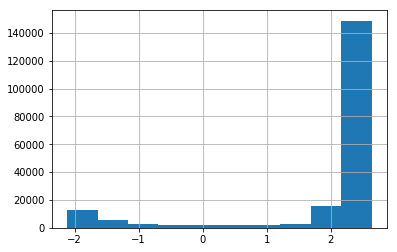

In [24]:
#img
plt.hist(data['img'].numpy().flatten())
plt.grid();

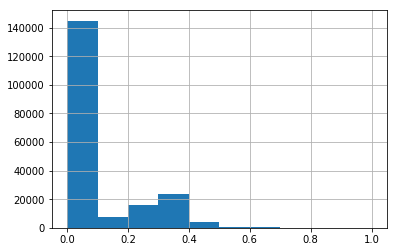

In [25]:
#targetmap
plt.hist(data['targetmap'].numpy().flatten())
plt.grid();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


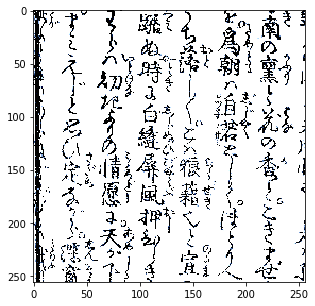

In [26]:
plt.figure(figsize=(5,5))
plt.imshow(data['img'].numpy().transpose(1,2,0));

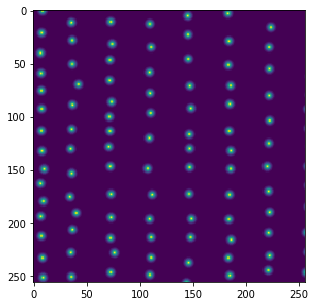

In [27]:
#heatmap
plt.figure(figsize=(5,5))
plt.imshow(data['targetmap'].numpy()[0]);

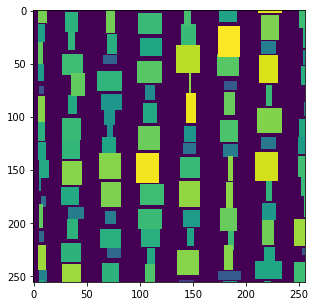

In [28]:
#heightmap
plt.figure(figsize=(5,5))
plt.imshow(data['targetmap'].numpy()[1]);

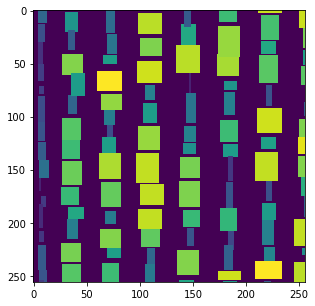

In [29]:
#widthmap
plt.figure(figsize=(5,5))
plt.imshow(data['targetmap'].numpy()[2]);

# Model

In [30]:
model = HGNET_RESNET34(load_weights=False)
for p in model.parameters():
    p.required_grad = True
print('number of params = ', count_parameters(model))
del model
gc.collect()

number of params =  71300608


17265

# Train

In [31]:
%%time
res = run_HGNet(train_names, valid_names, device, transform_train, transform_valid,
              fold, LOAD_LOCAL_WEIGHT_PATH, OUTPUT_PATH, config)

fold =  0
lr :  [9.939057285945933e-05]


/home/takesako/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))



epoch 1 loss_trn = 0.00545, loss_val = 0.00335, trn_score = 0.2239, val_score = 0.4951
model (best loss) saved
model (best score) saved

lr :  [9.757729755661011e-05]



epoch 2 loss_trn = 0.00237, loss_val = 0.00259, trn_score = 0.4294, val_score = 0.5388
model (best loss) saved
model (best score) saved

lr :  [9.460482294732421e-05]



epoch 3 loss_trn = 0.00198, loss_val = 0.00236, trn_score = 0.4718, val_score = 0.5740
model (best loss) saved
model (best score) saved

lr :  [9.05463412215599e-05]



epoch 4 loss_trn = 0.00179, loss_val = 0.00215, trn_score = 0.4938, val_score = 0.5804
model (best loss) saved
model (best score) saved

lr :  [8.55017856687341e-05]



epoch 5 loss_trn = 0.00168, loss_val = 0.00206, trn_score = 0.5070, val_score = 0.5800
model (best loss) saved

lr :  [7.959536998847742e-05]



epoch 6 loss_trn = 0.00159, loss_val = 0.00206, trn_score = 0.5174, val_score = 0.5950
model (best loss) saved
model (best score) saved

lr :  [7.297252973710757e-05]



epoch 7 loss_trn = 0.00152, loss_val = 0.00209, trn_score = 0.5245, val_score = 0.5770

lr :  [6.57963412215599e-05]



epoch 8 loss_trn = 0.00146, loss_val = 0.00195, trn_score = 0.5321, val_score = 0.5992
model (best loss) saved
model (best score) saved

lr :  [5.8243506019491436e-05]



epoch 9 loss_trn = 0.00141, loss_val = 0.00192, trn_score = 0.5391, val_score = 0.6060
model (best loss) saved
model (best score) saved

lr :  [5.05e-05]



epoch 10 loss_trn = 0.00136, loss_val = 0.00193, trn_score = 0.5449, val_score = 0.5952
 elapsed_time = 324.5 min

lr :  [4.2756493980508586e-05]



epoch 11 loss_trn = 0.00130, loss_val = 0.00192, trn_score = 0.5528, val_score = 0.5975
model (best loss) saved

lr :  [3.5203658778440106e-05]



epoch 12 loss_trn = 0.00125, loss_val = 0.00190, trn_score = 0.5587, val_score = 0.6065
model (best loss) saved
model (best score) saved

lr :  [2.8027470262892437e-05]



epoch 13 loss_trn = 0.00121, loss_val = 0.00182, trn_score = 0.5652, val_score = 0.6146
model (best loss) saved
model (best score) saved

lr :  [2.1404630011522586e-05]



epoch 14 loss_trn = 0.00116, loss_val = 0.00179, trn_score = 0.5726, val_score = 0.6203
model (best loss) saved
model (best score) saved

lr :  [1.54982143312659e-05]



epoch 15 loss_trn = 0.00111, loss_val = 0.00181, trn_score = 0.5780, val_score = 0.6191

lr :  [1.0453658778440109e-05]



epoch 16 loss_trn = 0.00107, loss_val = 0.00181, trn_score = 0.5843, val_score = 0.6240
model (best score) saved

lr :  [6.395177052675795e-06]



epoch 17 loss_trn = 0.00104, loss_val = 0.00181, trn_score = 0.5893, val_score = 0.6240
model (best score) saved

lr :  [3.4227024433899e-06]



epoch 18 loss_trn = 0.00102, loss_val = 0.00180, trn_score = 0.5928, val_score = 0.6255
model (best score) saved
model saved epoch18 for snapshot ensemble

lr :  [1.6094271405406859e-06]



epoch 19 loss_trn = 0.00100, loss_val = 0.00180, trn_score = 0.5949, val_score = 0.6263
model (best score) saved
model saved epoch19 for snapshot ensemble

lr :  [1e-06]



epoch 20 loss_trn = 0.00100, loss_val = 0.00179, trn_score = 0.5963, val_score = 0.6270
 elapsed_time = 645.6 min
model (best loss) saved
model (best score) saved
model saved epoch20 for snapshot ensemble

epoch_best 20, val_loss_best 0.00179, val_score_best 0.62699

CPU times: user 1d 14h 52min 42s, sys: 3h 54min 14s, total: 1d 18h 46min 57s
Wall time: 10h 45min 41s


In [32]:
log_df = res['log_df']

fold =  0


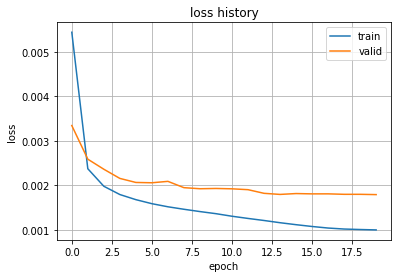

In [33]:
for fold in [fold]:
    print('fold = ', fold)
    log_df_tmp = log_df[log_df['fold']==fold].reset_index(drop=True)
    plot_loss(log_df_tmp)

fold =  0


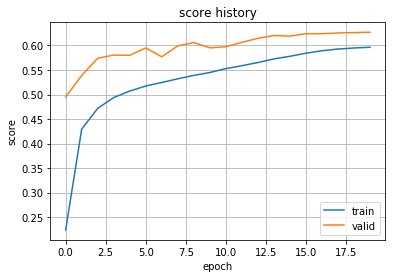

In [34]:
for fold in [fold]:
    print('fold = ', fold)
    log_df_tmp = log_df[log_df['fold']==fold].reset_index(drop=True)
    plot_score(log_df_tmp, col1='trn_score',col2='val_score')

fold =  0


/home/takesako/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 256, 256]) torch.Size([16, 256, 256])


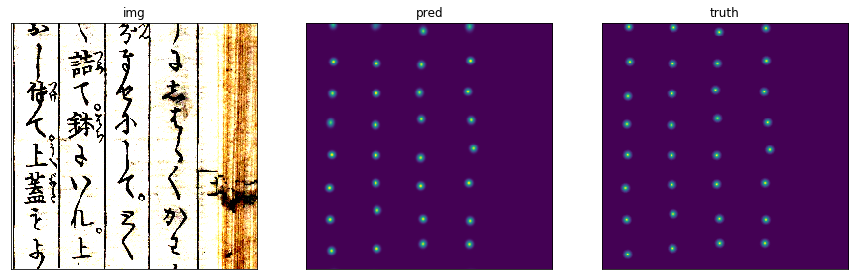

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


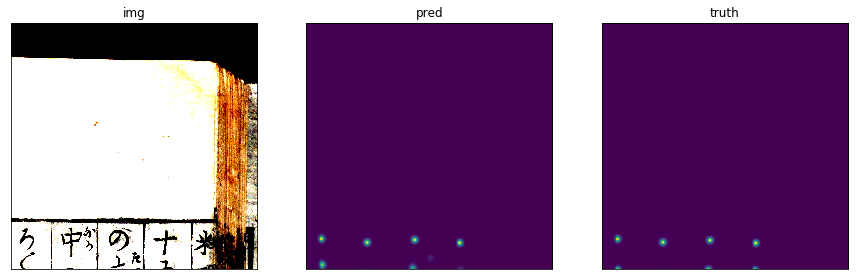

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


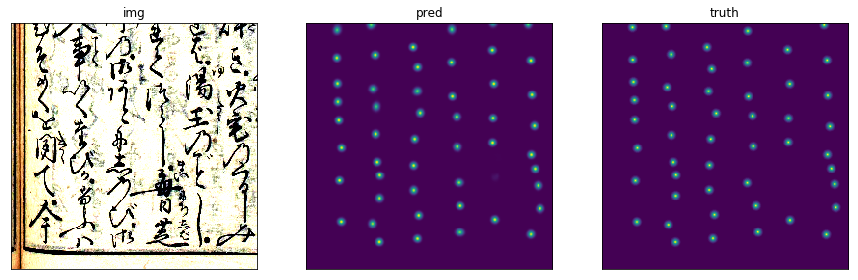

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


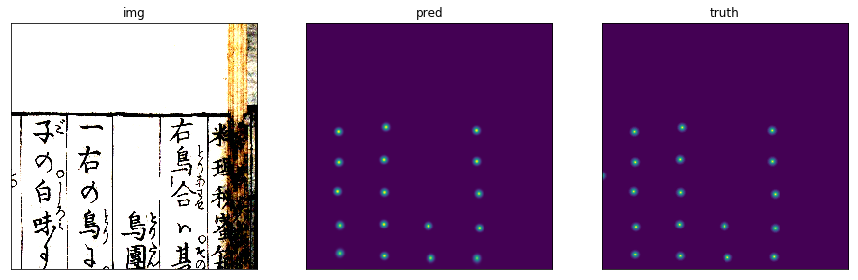

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


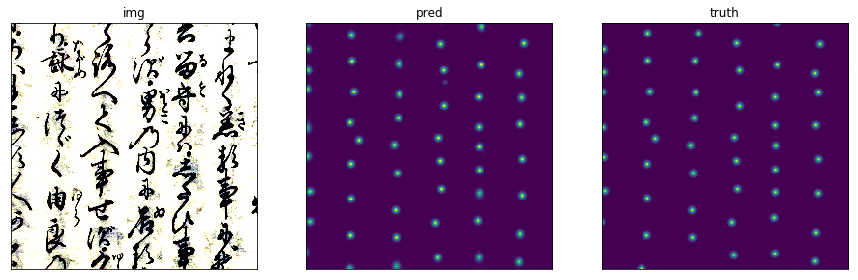

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


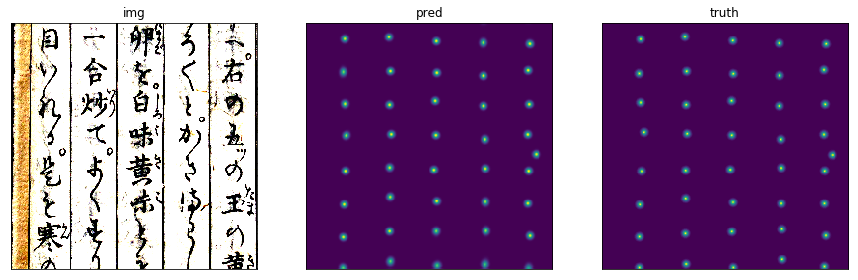

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


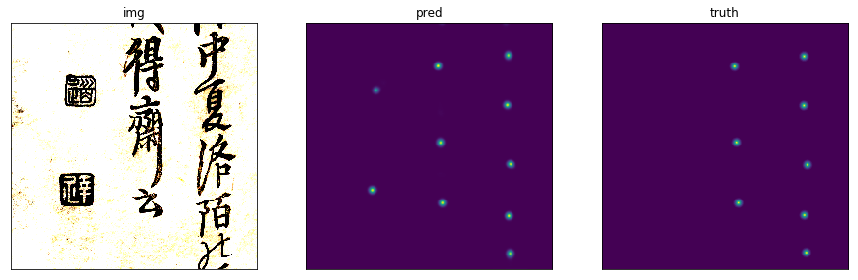

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


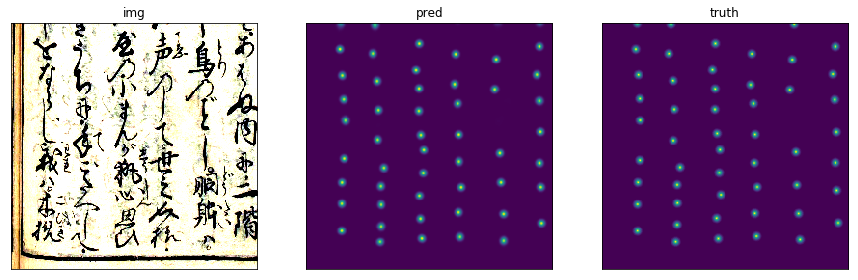

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


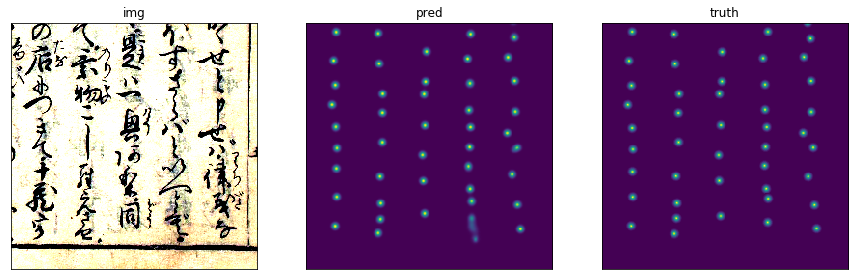

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


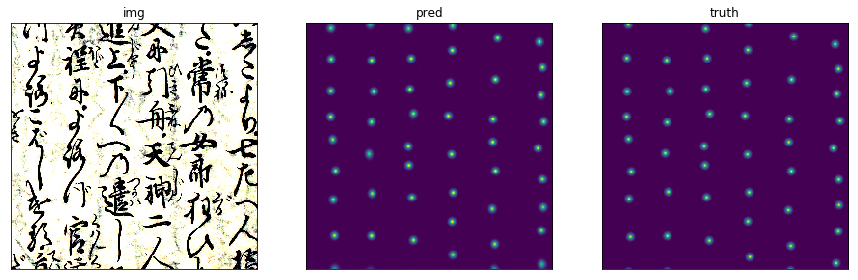

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


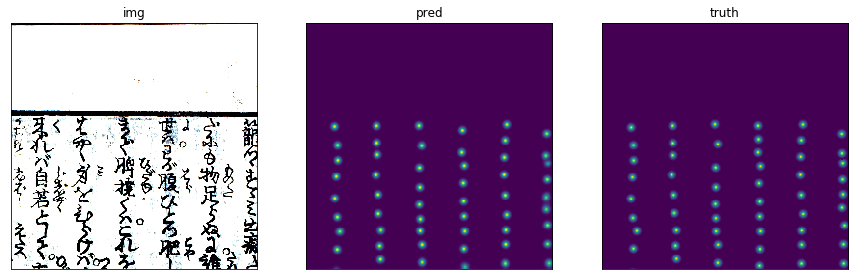

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


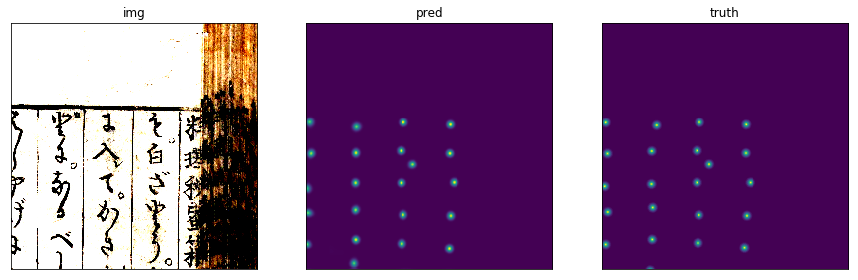

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


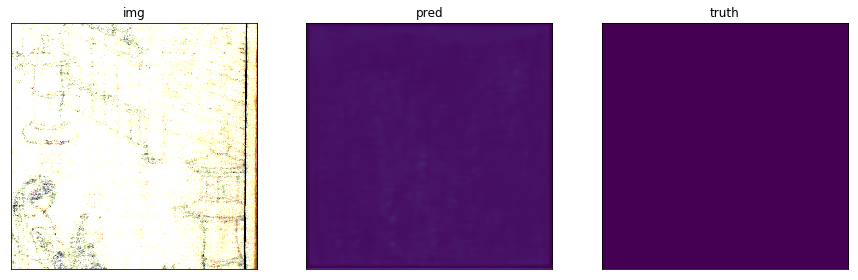

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


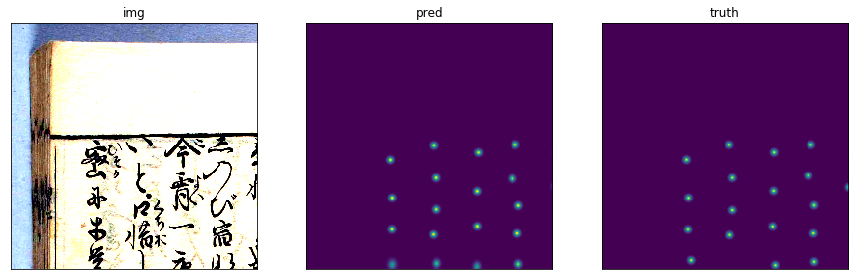

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


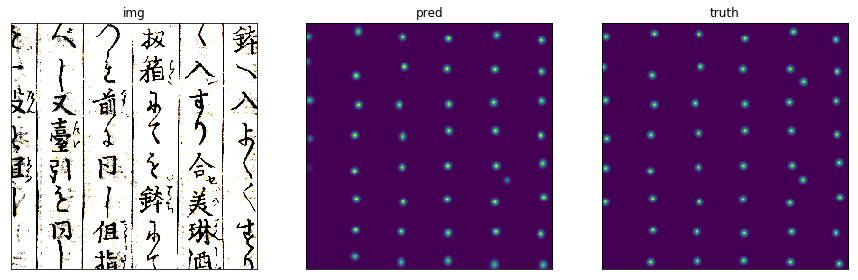

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


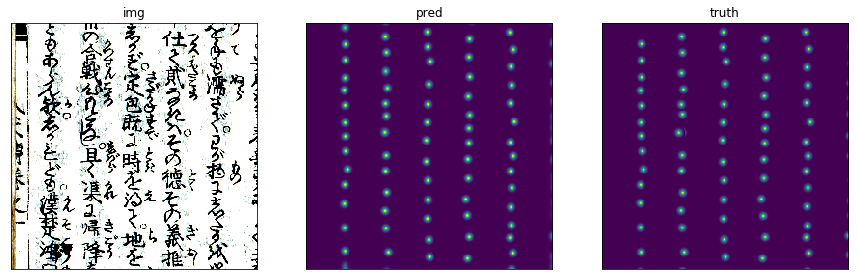

In [35]:
for fold in [fold]:
    print('fold = ', fold)
    data_val = valid_names
    valid_dataset = KuzushijiDetectionDatasetTrain(data=data_val,
                                                   transform=transform_valid)
    valid_loader  = DataLoader(valid_dataset, batch_size=config['test_batch_size'],
                               shuffle=False, num_workers=4, pin_memory=True)

    for data in valid_loader:
        break
    
    model = HGNET_RESNET34(load_weights=False).to(device, torch.float32)
    model.load_state_dict(torch.load(OUTPUT_PATH+f'model_fold{fold}_bestscore.pth'))
    model.eval();
    logits,logits2 = model(data['img'].to(device, torch.float32, non_blocking=True))
    batch,c,h,w = logits.size()
    x = torch.sigmoid(logits2[:,0,:,:]).cpu().detach()
    y = data['targetmap'][:,0,:,:].contiguous().to(device, torch.float32, non_blocking=True).cpu().detach()
    print(x.shape, y.shape)

    for idx in range(config['test_batch_size']):
        show_val_predictions(data['img'][idx], x[idx], y[idx])

    del logits, x,y, model, logits2
    torch.cuda.empty_cache()
    gc.collect()
    print('')

# Post-Prosessing Example

200021712-00065_2.jpg


/home/takesako/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


otputs.shape =  (138, 4)


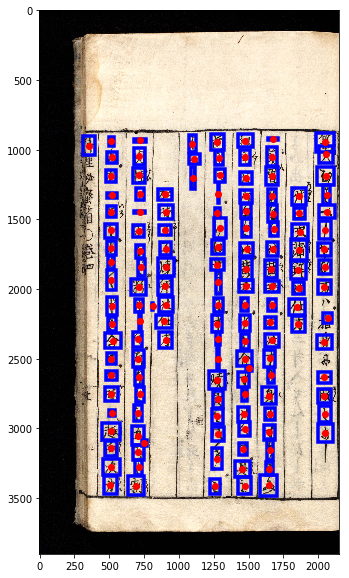

9894

In [36]:
fold  = 0
model = HGNET_RESNET34(load_weights=False).to(device, torch.float32)
model.load_state_dict(torch.load(OUTPUT_PATH+f'model_fold{fold}_bestscore.pth'))
model.eval();

postprosessing(0, ['200021712-00065_2.jpg'], model, device)

del model
torch.cuda.empty_cache()
gc.collect()

# Check Validation F1 Score for Detection

In [24]:
valid_preds  = valid_df.copy()
valid_preds2 = valid_df.copy()
for i in range(len(valid_preds)):
    valid_preds.loc[i,'labels']  = np.nan
    valid_preds2.loc[i,'labels'] = np.nan
    
    
fold  = 0 
model = HGNET_RESNET34(load_weights=False).to(device, torch.float32)
model.load_state_dict(torch.load(OUTPUT_PATH+f'model_fold{fold}_bestscore.pth'))
model.eval();
    
    
for i in tqdm(range(len(valid_preds))):
    fname = valid_preds.loc[i,'image_id'] + '.jpg'
    img = preprocessing(fname, test_mode=True) #(h,w,c)
    
    im_height, im_width, colour_depth = img.shape
    # for now just a square area around center
    r=128  # 256x256
    
    predictions  = []
    predictions2 = []
    
    outputs = get_centers(img, model, device, hm_threshold=20, hm_min_distance=10)
    
    for center_x, center_y, w, h in outputs:
        center_x = int(center_x)
        center_y = int(center_y)
        x0, y0 = max(0, center_x - r), max(0, center_y - r)
        x1, y1 = center_x + r, center_y + r
        character_region = img[y0:y1, x0:x1]
        prediction = np.nan #classifier.predict(stable.predict.preprocess_input(character_region))[0].obj
        predictions.append([prediction, center_x, center_y])
        predictions2.append([prediction, center_x, center_y, int(w), int(h)])

    if len(predictions) > 0:
        predictions_str = " ".join([" ".join(map(str, i)) for i in predictions])
        valid_preds.loc[i,'labels'] = predictions_str
    else:
        valid_preds.loc[i,'labels'] = np.nan
        
    if len(predictions2) > 0:
        predictions_str = " ".join([" ".join(map(str, i)) for i in predictions2])
        valid_preds2.loc[i,'labels'] = predictions_str
    else:
        valid_preds2.loc[i,'labels'] = np.nan
        
del model
torch.cuda.empty_cache()
gc.collect()

/home/takesako/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


43

In [38]:
#score
val_f1_score = f1.kuzushiji_f1(valid_preds, valid_df, detection_only=True)
print('val_f1_score = {:.4f}'.format(val_f1_score))

#save
valid_preds.to_csv(OUTPUT_PATH+f'valid_preds_fold{fold}.csv', index=False)

val_f1_score = 0.9856


# Test

In [39]:
submission = pd.read_csv(DATA/"sample_submission.csv")
for i in range(len(submission)):
    submission.loc[i,'labels'] = np.nan

In [40]:
fold  = 0 
model = HGNET_RESNET34(load_weights=False).to(device, torch.float32)
model.load_state_dict(torch.load(OUTPUT_PATH+f'model_fold{fold}_bestscore.pth'))
model.eval();
    
for i in tqdm(range(len(submission))):
    fname = submission.loc[i,'image_id'] + '.jpg'
    img = preprocessing(fname, test_mode=True) #(h,w,c)
    
    im_height, im_width, colour_depth = img.shape
    # for now just a square area around center
    r=128  # 256x256
    
    predictions = []
    
    outputs = get_centers(img, model, device, hm_threshold=20, hm_min_distance=10)
    
    for center_x, center_y, w, h in outputs:
        center_x = int(center_x)
        center_y = int(center_y)
        x0, y0 = max(0, center_x - r), max(0, center_y - r)
        x1, y1 = center_x + r, center_y + r
        character_region = img[y0:y1, x0:x1]
        prediction = np.nan #classifier.predict(stable.predict.preprocess_input(character_region))[0].obj
        predictions.append([prediction, center_x, center_y, int(w), int(h)])

    if len(predictions) > 0:
        predictions_str = " ".join([" ".join(map(str, i)) for i in predictions])
        submission.loc[i,'labels'] = predictions_str
    else:
        submission.loc[i,'labels'] = np.nan
        
del model
torch.cuda.empty_cache()
gc.collect()

/home/takesako/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


32

In [41]:
submission.to_csv(OUTPUT_PATH+f'detection_result.csv', index=False)

In [42]:
pd.read_csv(OUTPUT_PATH+f'detection_result.csv').head()

,image_id,labels
0,test_00145af3,nan 588 608 78 81 nan 1408 612 91 70 nan 104 6...
1,test_001c37e2,nan 1024 756 57 62 nan 1176 772 19 77 nan 1316...
2,test_003aa33a,nan 840 748 23 51 nan 1156 756 36 65 nan 520 7...
3,test_00665e33,nan 488 548 57 81 nan 1216 548 103 86 nan 636 ...
4,test_006964dc,nan 1784 580 96 14 nan 464 596 35 89 nan 636 5...


# IOU for Validation

In [25]:
mean_iou = []
for idx in tqdm(range(len(valid_df))):
    path = valid_df.loc[idx, 'image_id']+'.jpg'
    img = preprocessing(path, test_mode=True)
    h,w = img.shape[:2]

    truth_map = np.zeros((h,w))
    preds_map = np.zeros((h,w))

    if not valid_df.iloc[idx].isnull()['labels']:
        labels = np.array(valid_df.loc[idx, 'labels'].split(' ')).reshape(-1,5)
        for ch,x,y,w,h in labels:
            x,y,w,h = int(x),int(y),int(w),int(h)
            xc,yc = x+w//2,y+h//2
            if w>0 and h>0:
                truth_map[yc-h//2:yc+h//2+1, xc-w//2:xc+w//2+1] = 1

    if not valid_preds2.iloc[idx].isnull()['labels']:
        labels = np.array(valid_preds2.loc[idx, 'labels'].split(' ')).reshape(-1,5)
        for ch,xc,yc,w,h in labels:
            xc,yc,w,h = int(xc),int(yc),int(w),int(h)
            if w>0 and h>0:
                preds_map[yc-h//2:yc+h//2+1, xc-w//2:xc+w//2+1] = 1

    smooth = 1e-12
    numerator   = np.sum(truth_map*preds_map) + smooth
    denominator = truth_map.sum() + preds_map.sum() - np.sum(truth_map*preds_map) + smooth
    iou =  numerator / denominator 
    mean_iou.append(iou)
mean_iou = sum(mean_iou)/len(mean_iou)

print('mean_iou = {:.4f}'.format(mean_iou))


mean_iou = 0.8142


# Look at Test Predictions

test_01e41977.jpg


/home/takesako/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


otputs.shape =  (187, 4)


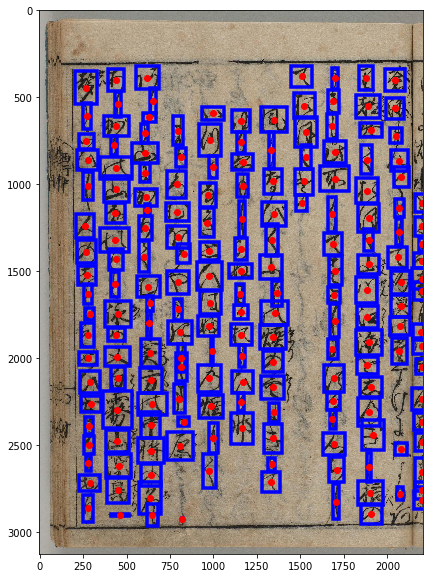

14616

In [30]:
fold  = 0
model = HGNET_RESNET34(load_weights=False).to(device, torch.float32)
model.load_state_dict(torch.load(OUTPUT_PATH+f'model_fold{fold}_bestscore.pth'))
model.eval();

postprosessing(0, ['test_01e41977.jpg'], model, device)

del model
torch.cuda.empty_cache()
gc.collect()

test_021661ed.jpg


/home/takesako/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


otputs.shape =  (211, 4)


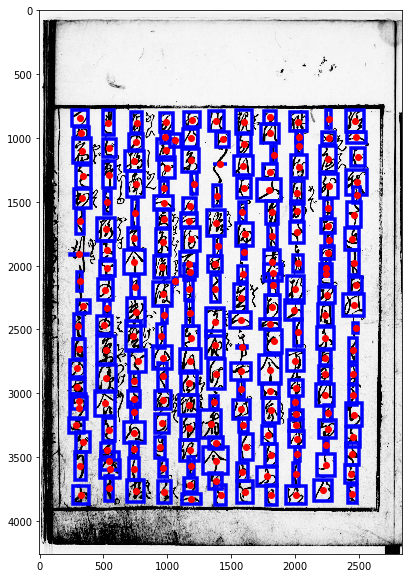

13656

In [31]:
fold  = 0
model = HGNET_RESNET34(load_weights=False).to(device, torch.float32)
model.load_state_dict(torch.load(OUTPUT_PATH+f'model_fold{fold}_bestscore.pth'))
model.eval();

postprosessing(0, ['test_021661ed.jpg'], model, device)

del model
torch.cuda.empty_cache()
gc.collect()